# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">2.5 Hours</span>
* 2. Part B: <span style="color:red;">2.5 Hours</span>
* 3. Part C: <span style="color:red;">2 Hours</span>
* 4. Tests: <span style="color:red;">15 Minutes</span>
* 5. Challenge 1: <span style="color:red;">30 Minutes</span>
* 6. Challenge 2: <span style="color:red;">2 Hours</span>
* 7. Write-up: <span style="color:red;">15 Minutes</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import exception

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

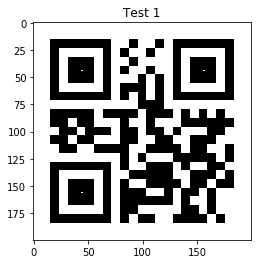

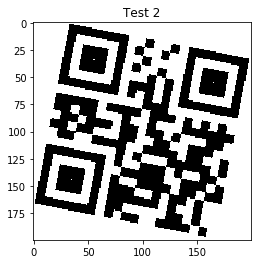

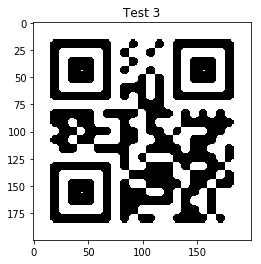

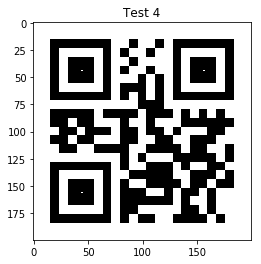

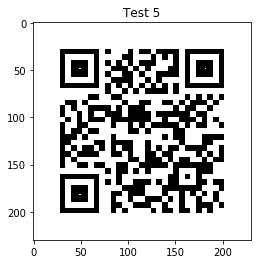

In [14]:
def getCenters(code, debug=False, threshold=2, threshold2=4):
    blackCount = 0
    whiteCount = 0
    blackContinue = True
    finalContinue = False
    centers = []
    finalCenters = []
    for row in range(len(code)):
        for col in range(len(code[row])):
            if code[row, col] == 0 and blackContinue is True and finalContinue is False:
                blackCount += 1
            elif code[row, col] == 0 and blackContinue is False and finalContinue is False:
                if blackCount - threshold < whiteCount and blackCount + threshold > whiteCount:
                    finalContinue = True
                    blackCount = 1
                else:
                    blackCount = 1
                    whiteCount = 0
                    blackContinue = True
            elif code[row, col] == 0 and finalContinue is True:
                blackCount += 1
            elif code[row, col] == 255:
                if finalContinue is True and whiteCount * 3 + threshold2 and blackCount > whiteCount * 3 - threshold2:
                    centers.append([row, math.floor(col - .5 * blackCount)])
                    blackCount = 0
                    whiteCount = 0
                elif finalContinue:
                    blackCount = 0
                    whiteCount = 0
                else:
                    whiteCount += 1
                finalContinue = False
                blackContinue = False
            if col is len(code[row]) - 1:
                blackCount = 0

    for col in range(len(code[0])):
        for row in range(len(code)):
            if code[row, col] == 0 and blackContinue is True and finalContinue is False:
                blackCount += 1
            elif code[row, col] == 0 and blackContinue is False and finalContinue is False:
                if blackCount - threshold < whiteCount and blackCount + threshold > whiteCount:
                    finalContinue = True
                    blackCount = 1
                else:
                    blackCount = 1
                    whiteCount = 0
                    blackContinue = True
            elif code[row, col] == 0 and finalContinue is True:
                blackCount += 1
            elif code[row, col] == 255:
                if finalContinue is True and blackCount < whiteCount * 3 + threshold2 and blackCount > whiteCount * 3 - threshold2:
                    isIn = False
                    newArray = [math.floor(row - .5 * blackCount), col]
                    newArray1 = [math.floor(row - .5 * blackCount), col - 1]
                    newArray2 = [math.floor(row - .5 * blackCount), col + 1]
                    newArray3 = [math.floor(row - .5 * blackCount) - 1, col]
                    newArray4 = [math.floor(row - .5 * blackCount) + 1, col]
                    newArray5 = [math.floor(row - .5 * blackCount) - 1, col - 1]
                    newArray6 = [math.floor(row - .5 * blackCount) + 1, col + 1]
                    newArray7 = [math.floor(row - .5 * blackCount) - 1, col + 1]
                    newArray8 = [math.floor(row - .5 * blackCount) + 1, col - 1]
                    for x in range(len(centers)):
                        if (np.array_equal(centers[x], newArray) or np.array_equal(centers[x], newArray1)):
                            isIn = True
                            found = False
                            for y in range(len(finalCenters)):
                                if (np.array_equal(finalCenters[y], newArray) or np.array_equal(finalCenters[y], newArray1)
                                        or np.array_equal(finalCenters[y], newArray2) or np.array_equal(finalCenters[y], newArray3)
                                        or np.array_equal(finalCenters[y], newArray4) or np.array_equal(finalCenters[y], newArray5)
                                        or np.array_equal(finalCenters[y], newArray6) or np.array_equal(finalCenters[y], newArray7)
                                        or np.array_equal(finalCenters[y], newArray8)):
                                    found = True
                            if found is False:
                                finalCenters.append(newArray)
                    if isIn and debug is True:
                        code[math.floor(row - .5 * blackCount), col] = 255
                    blackCount = 0
                    whiteCount = 0
                elif finalContinue:
                    blackCount = 0
                    whiteCount = 0
                else:
                    whiteCount += 1
                finalContinue = False
                blackContinue = False
            if row is len(code[0]) - 1:
                blackCount = 0
    return finalCenters, code

def getCentersWrap(code, debug=False):
    finalCenters, code = getCenters(code, debug)
    if finalCenters == []:
        finalCenters, code = getCenters(code, debug, 8, 10)
    return finalCenters, code

code = cv2.imread("QR_codes/test1.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
plt.imshow(code, cmap="gray")
plt.title('Test 1')
plt.show()

code2 = cv2.imread("QR_codes/test2.png", 0)
ret, code2 = cv2.threshold(code2, 127, 255, cv2.THRESH_BINARY)
finalCenters2, code2 = getCentersWrap(code2, True)
plt.imshow(code2, cmap="gray")
plt.title('Test 2')
plt.show()

code3 = cv2.imread("QR_codes/test3.png", 0)
ret, code3 = cv2.threshold(code3, 127, 255, cv2.THRESH_BINARY)
finalCenters3, code3 = getCentersWrap(code3, True)
plt.imshow(code3, cmap="gray")
plt.title('Test 3')
plt.show()

code4 = cv2.imread("QR_codes/test4.png", 0)
ret, code4 = cv2.threshold(code4, 127, 255, cv2.THRESH_BINARY)
finalCenters4, code4 = getCentersWrap(code4, True)
plt.imshow(code4, cmap="gray")
plt.title('Test 4')
plt.show()

code5 = cv2.imread("QR_codes/test5.png", 0)
ret, code5 = cv2.threshold(code5, 127, 255, cv2.THRESH_BINARY)
finalCenters5, code5 = getCentersWrap(code5, True)
plt.imshow(code5, cmap="gray")
plt.title('Test 5')
plt.show()

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

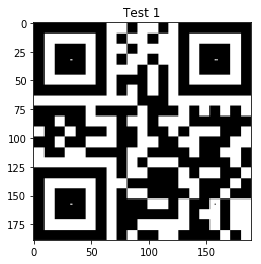

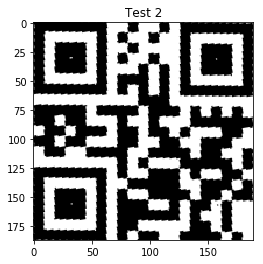

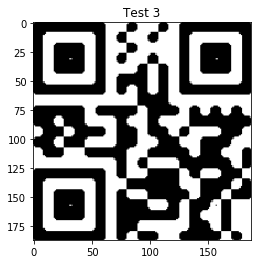

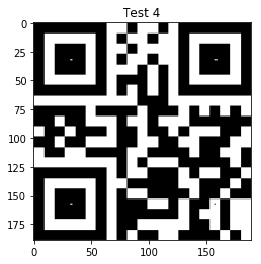

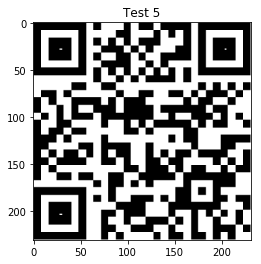

In [11]:
def getPoints(finalCenters, code, debug=False):
    bottomRight, bottomLeftIndex, topLeftIndex, topRightIndex = getPointsHelp(finalCenters)
    try:
        test = code[bottomRight[0], bottomRight[1]]
    except Exception as e:
        (h, w) = code.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), 90, 1)
        code = cv2.warpAffine(code, M, (h, w))
        finalCenters, code = getCentersWrap2(code)
        bottomRight, bottomLeftIndex, topLeftIndex, topRightIndex = getPointsHelp(finalCenters)
    if debug is True:
        code[bottomRight[0], bottomRight[1]] = 0
    newFinalCenters = [finalCenters[topLeftIndex], finalCenters[topRightIndex], finalCenters[bottomLeftIndex], bottomRight]
    return np.array(newFinalCenters), code

def getPointsHelp(finalCenters):
    topRight = finalCenters[0][1]
    bottomLeft = finalCenters[0][0]
    topRightIndex = 0
    bottomLeftIndex = 0
    topLeftIndex = 0
    for x in range(len(finalCenters)):
        if finalCenters[x][1] > topRight:
            topRightIndex = x
            topRight = finalCenters[x][1]
        if finalCenters[x][0] > bottomLeft:
            bottomLeftIndex = x
            bottomLeft = finalCenters[x][0]

    if (topRightIndex == 0 and bottomLeftIndex == 1) or (topRightIndex == 1 and bottomLeftIndex == 0):
        topLeftIndex = 2
    elif (topRightIndex == 0 and bottomLeftIndex == 2) or (topRightIndex == 2 and bottomLeftIndex == 0):
        topLeftIndex = 1
    elif (topRightIndex == 1 and bottomLeftIndex == 2) or (topRightIndex == 2 and bottomLeftIndex == 1):
        topLeftIndex = 0

    bottomRight = ([finalCenters[bottomLeftIndex][0] + finalCenters[topRightIndex][0] - finalCenters[topLeftIndex][0],
                    finalCenters[bottomLeftIndex][1] + finalCenters[topRightIndex][1] - finalCenters[topLeftIndex][1]])
    return bottomRight, bottomLeftIndex, topLeftIndex, topRightIndex


def getWarped(code, finalCenters):
    h, status = cv2.findHomography(finalCenters, np.array([[0, 0], [0, 100], [100, 0], [100, 100]]))
    inv = np.linalg.inv(h)
    height, width = code.shape[:2]
    corners = np.array([
        [0, 0],
        [0, height - 1],
        [width - 1, height - 1],
        [width - 1, 0]
    ])
    corners = cv2.perspectiveTransform(np.float32([corners]), inv)[0]
    bx, by, bwidth, bheight = cv2.boundingRect(corners)

    M = np.float32([[1, 0, -bx], [0, 1, -by], [0, 0, 1]])
    finalHom = M.dot(inv)

    code = cv2.warpPerspective(code, finalHom, (bwidth, bheight))
    black = True
    black2 = False
    kwan = cv2.perspectiveTransform(np.float32([finalCenters]), finalHom)[0]
    xy = int(kwan[0, 0]) - 2
    while 1:
        if black is True and code[xy, xy] <= 127:
            xy -= 1
        elif code[xy, xy] >= 128:
            if black2 is False:
                black = False
                xy -= 1
            else:
                break
        elif black is False and code[xy, xy] <= 127:
            black2 = True
            xy -= 1
    code = code[xy:bheight - xy, xy:bwidth - xy]
    return code

code = cv2.imread("QR_codes/test1.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
plt.imshow(code, cmap="gray")
plt.title('Test 1')
plt.show()

code = cv2.imread("QR_codes/test2.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
plt.imshow(code, cmap="gray")
plt.title('Test 2')
plt.show()

code = cv2.imread("QR_codes/test3.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
plt.imshow(code, cmap="gray")
plt.title('Test 3')
plt.show()

code = cv2.imread("QR_codes/test4.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
plt.imshow(code, cmap="gray")
plt.title('Test 4')
plt.show()

code = cv2.imread("QR_codes/test5.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
plt.imshow(code, cmap="gray")
plt.title('Test 5')
plt.show()


### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [7]:
def discretize(code, num, inc, size=168):
    code = cv2.resize(code, (size, size), interpolation=cv2.INTER_CUBIC)
    disc21 = np.zeros((num, num))
    currRow = 0
    currCol = 0
    for row in range(num):
        for col in range(num):
            mean = np.mean(code[currRow:currRow + inc, currCol:currCol + inc])
            if mean <= 128:
                disc21[row, col] = False
            else:
                disc21[row, col] = True
            currCol += inc
        currRow += inc
        currCol = 0

    return disc21

def getCorrectArray(code):
    disc21 = discretize(code, 21, 8)
    disc25 = discretize(code, 25, 8, 200)
    disc29 = discretize(code, 29, 7, 203)
    disc33 = discretize(code, 33, 6, 198)

    disc21 = getArray(disc21, 7)
    disc25 = getArray(disc25, 11)
    disc29 = getArray(disc29, 15)
    disc33 = getArray(disc33, 19)
    if disc21 is not None:
        return disc21
    elif disc25 is not None:
        return disc25
    elif disc29 is not None:
        return disc29
    elif disc33 is not None:
        return disc33
    else:
        return None

def getArray(disc21, size=7):
    row = 6
    col = 7
    correct = True
    right = True
    for i in range(size):
        if correct == disc21[row, col]:
            correct = not correct
            col += 1
        else:
            right = False
            break
    if right is True:
        row = 7
        col = 6
        correct = True
        for i in range(size):
            if correct == disc21[row, col]:
                correct = not correct
                row += 1
            else:
                right = False
                break
        if right is True:
            return disc21
    else:
        return None
    
code = cv2.imread("QR_codes/test1.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
print(disc)


[[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 1.

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [8]:
from decoder import decode

code = cv2.imread("QR_codes/test1.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)

output = decode(disc)
print("Test 1: " + output)

code = cv2.imread("QR_codes/test2.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)

output = decode(disc)
print("Test 2: " + output)

code = cv2.imread("QR_codes/test3.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)

output = decode(disc)
print("Test 3: " + output)

code = cv2.imread("QR_codes/test4.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)

output = decode(disc)
print("Test 4: " + output)

code = cv2.imread("QR_codes/test5.png", 0)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)

output = decode(disc)
print("Test 5: " + output)

Test 1: http://byu.edu
Test 2: http://byu.edu
Test 3: http://byu.edu
Test 4: http://byu.edu
Test 5: http://DataGenetics.com


## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

Test 1: http://byu.edu


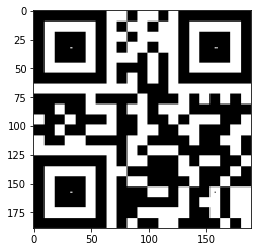

Test 2: http://byu.edu


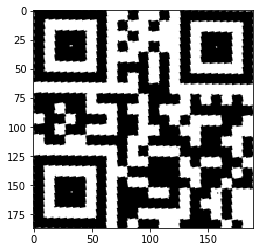

Test 3: http://byu.edu


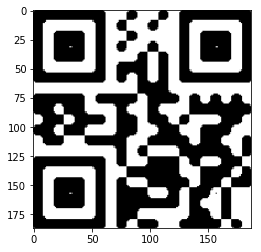

Test 4: http://byu.edu


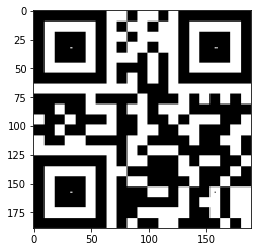

Test 5: http://DataGenetics.com


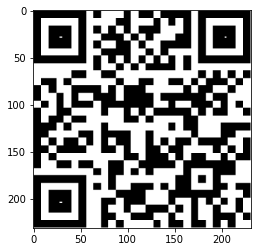

In [9]:
code = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Test 1: " + output)
plt.imshow(code,cmap="gray");
plt.show()

code = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Test 2: " + output)
plt.imshow(code,cmap="gray");
plt.show()

code = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Test 3: " + output)
plt.imshow(code,cmap="gray");
plt.show()

code = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Test 4: " + output)
plt.imshow(code,cmap="gray");
plt.show()

code = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Test 5: " + output)
plt.imshow(code,cmap="gray");
plt.show()


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



Challenge 3: http://byu.edu


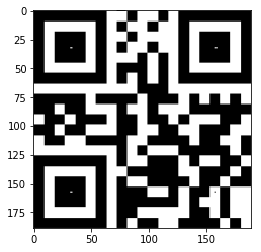

Challenge 1: http://byu.edu


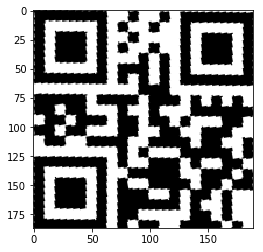

In [15]:
code = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, True)
finalCenters, code = getPoints(finalCenters, code, True)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Challenge 3: " + output)
plt.imshow(code,cmap="gray");
plt.show()

code = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
ret, code = cv2.threshold(code, 127, 255, cv2.THRESH_BINARY)
finalCenters, code = getCentersWrap(code, False)
finalCenters, code = getPoints(finalCenters, code, False)
code = getWarped(code, finalCenters)
disc = getCorrectArray(code)
output = decode(disc)
print("Challenge 1: " + output)
plt.imshow(code,cmap="gray");
plt.show()



## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

I feel like each part of the lab had a fairly similar difficulty, but sections A and B were definitely the hardest.

For section A, I solved the problem by simply iterating over the image horizontally looking for that 1:1:3:1:1 pattern, and then I did it again vertically in similar fashion. Those pixels that mached (+- 1) were added to the list of of boxes. For section B, I used the locations of the three points I found in section A to locate a fourth point and create a homography, which I then used to transform the image. In order to crop the image, I simply started at the center of a corner box, and worked my way out diagonally through layers of black, white, and black again until I hit a white pixel. This method wasn't 100% perfect, but it was very close and sufficient for my needs. In order to decode, in part C I used a double for loop and averaged all the pixels within discreet windows, and then added that to an array. I did this for each size that I wanted to check for. In order to know which of these arrays was correct, I checked the timing marks for each possible version and found the one that matched. Finally, I sent that array over to the decoder, and it sent back the meaning of the messages.

This lab was great! I think the only main issue I had, was that the example images in this notebook were displayed at full resolution, making it a pain to scroll between windows. A ton of coding was also involved for this one, and if there was a way to reduce the number of needed lines next time, I think that would be great.